# **Clasificación de imágenes de mamografía**

Fernando Barajas Ramírez - 2085375​

Leobardo García Reyes - 1616825

David Eduardo Gallardo - 0931556

## Librerías

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow.compat.v1 as tfv1

gpu_options = tfv1.GPUOptions(allow_growth=True)

session = tfv1.InteractiveSession(config=tfv1.ConfigProto(gpu_options=gpu_options))

### Descomprime y separa los datos en entrenamineto, validación y prueba

In [3]:
#!unzip '/content/drive/MyDrive/Mini-Proyecto/Dataset.zip' -d '/content/drive/MyDrive/Mini-Proyecto/'

In [4]:
#!pip install split-folders

In [5]:
#import splitfolders

In [6]:
#img_entrada = '/content/drive/MyDrive/Mini-Proyecto/Dataset/'

In [7]:
#splitfolders.ratio(img_entrada, output = '/content/drive/MyDrive/Mini-Proyecto/Dataset Chido',
#                   seed = 42, ratio = (0.7, 0.2, 0.1),
#                   group_prefix = None)

In [8]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 3.8 MB/s 


In [56]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
from PIL import ImageFont
from time import time
from statistics import mean

In [10]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import (Dense, Dropout, Conv2D, Flatten, AveragePooling2D, BatchNormalization,
                          Activation, MaxPooling2D, ZeroPadding2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.applications import Xception

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc,
                             ConfusionMatrixDisplay, f1_score, precision_recall_curve, recall_score, precision_score)

from keras.utils.vis_utils import plot_model
import visualkeras
from collections import defaultdict

## Datos

### Dirección de las carpetas

In [11]:
direccion_entrenamiento = '/content/drive/MyDrive/Mini-Proyecto/Dataset Chido/train'
direccion_validacion = '/content/drive/MyDrive/Mini-Proyecto/Dataset Chido/val'
direccion_prueba = '/content/drive/MyDrive/Mini-Proyecto/Dataset Chido/test'

### Conteo de las imágenes

In [12]:
def conteo_datos(direccion_archivo):
    conteo_clase = {}
    conteo_total = 0
    if 'pred' in direccion_archivo:
        return len(os.listdir(os.path.join(direccion_archivo))), conteo_clase
    else:
        for nombre_clase in os.listdir(os.path.join(direccion_archivo)):
            conteo = len(os.listdir(os.path.join(direccion_archivo, nombre_clase)))
            conteo_clase[nombre_clase] = conteo
            conteo_total += conteo
    return conteo_total, conteo_clase

In [13]:
conteo_entrenamiento, conteo_clase_entrenamiento = conteo_datos(direccion_entrenamiento)
conteo_validacion, conteo_clase_validacion = conteo_datos(direccion_validacion)
conteo_prueba, conteo_clase_prueba = conteo_datos(direccion_prueba)

print('Tamaño de datos de entrenamiento: ', conteo_entrenamiento, conteo_clase_entrenamiento)
print('Tamaño de datos de validación: ', conteo_validacion, conteo_clase_validacion)
print('Tamaño de datos de prueba: ', conteo_prueba, conteo_clase_prueba)

Tamaño de datos de entrenamiento:  5464 {'Benigno': 1878, 'Cancer': 1901, 'Normal': 1685}
Tamaño de datos de validación:  1560 {'Benigno': 536, 'Cancer': 543, 'Normal': 481}
Tamaño de datos de prueba:  785 {'Benigno': 270, 'Cancer': 273, 'Normal': 242}


### Imágenes de cada clase

In [14]:
# Guarda la dirección de la primera imagen de cada categría
etiquetas_imagenes = ['Normal', 'Benigno', 'Cancer']
carpeta = os.listdir(direccion_entrenamiento)

guardar_ima = []

for i in carpeta:
  aux = '/' + i
  aux2 = os.listdir(direccion_entrenamiento + aux)[0]
  aux3 = aux + '/'
  aux4 = aux3 + aux2
  aux5 = direccion_entrenamiento + aux4
  guardar_ima.append(aux5)

guardar_ima

['/content/drive/MyDrive/Mini-Proyecto/Dataset Chido/train/Benigno/A_1768_1.LEFT_CC.jpg',
 '/content/drive/MyDrive/Mini-Proyecto/Dataset Chido/train/Cancer/A_1626_1.LEFT_MLO.jpg',
 '/content/drive/MyDrive/Mini-Proyecto/Dataset Chido/train/Normal/A_0354_1.RIGHT_CC.jpg']

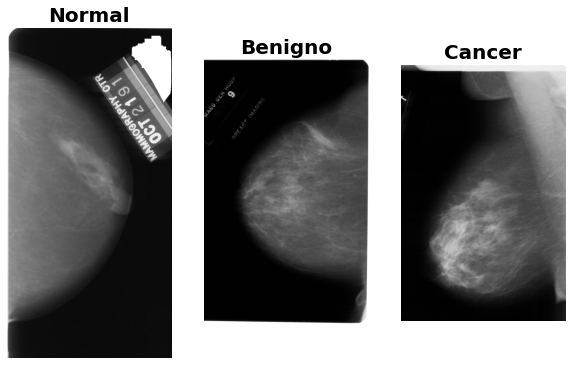

In [15]:
# Mostrar la primera imagen de cada categría
# Gráficar una imagen Orgánica y Reciclable
Normal = direccion_entrenamiento + '/Normal/A_0354_1.RIGHT_CC.jpg'
Normal2 = imread(Normal)
Benigno = direccion_entrenamiento + '/Benigno/A_1768_1.LEFT_CC.jpg'
Benigno2 = imread(Benigno)
Cancer = direccion_entrenamiento + '/Cancer/A_1626_1.LEFT_MLO.jpg'
Cancer2 = imread(Cancer)

Imagenes = [Normal2, Benigno2, Cancer2]
Etiquetas_imagenes = ['Normal', 'Benigno', 'Cancer']

for i in range(3):
    plt.figure(1, figsize = (10, 10))
    plt.subplot(1, 3, i + 1)
    plt.title(Etiquetas_imagenes[i], fontweight = 'bold', fontsize = 20)
    plt.imshow(Imagenes[i], cmap = 'gray', vmin = 0, vmax = 255)
    plt.axis('off')

plt.show()

### Dimensiones de las imágenes

In [16]:
# Checar dimensiones
ancho1 = []
alto1 = []

subcarpetas = ['/Normal', '/Benigno', '/Cancer']
carpeta = os.listdir(direccion_entrenamiento)

for i in subcarpetas:
  for j in os.listdir(direccion_entrenamiento + i):
    aux = direccion_entrenamiento + i
    aux2 = aux + '/'
    img = Image.open(aux2 + j)
    ancho, alto = img.size
    ancho1.append(ancho)
    alto1.append(alto)

print(mean(ancho1))
print(mean(alto1))

1535.914897510981
2676.2423133235725


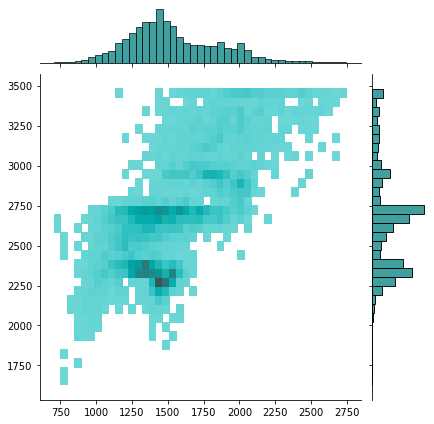

In [17]:
sns.jointplot(x = ancho1, y = alto1, kind = 'hist', color = 'teal')

### Pre-procesamiento de las imágenes

In [18]:
Nuevas_imagenes_entrenamineto = ImageDataGenerator(rescale = 1/255, # Normaliza las imágenes
                                                   horizontal_flip = True, # Voltea aleatoriamente las imágenes horizontalmente
                                                   vertical_flip = True, # Voltea aleatoriamente las imágenes verticalmente
                                                   )

Nuevas_imagenes_validacion = ImageDataGenerator(rescale = 1/255, # Normaliza las imágenes
                                                )


Nuevas_imagenes_prueba = ImageDataGenerator(rescale = 1/255 # Normaliza las imágenes
                                            )

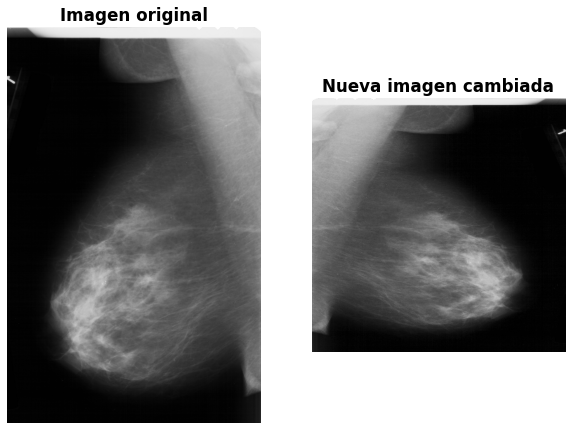

In [61]:
# Gráficar la imagen original con una imagen cambiada aleatoriamente
Cancer3 = direccion_entrenamiento + '/Cancer/A_1626_1.LEFT_MLO.jpg'
Cancer3 = cv2.imread(direccion_entrenamiento + '/Cancer/A_1626_1.LEFT_MLO.jpg')
res = cv2.resize(Cancer3, dsize=(400, 400), interpolation=cv2.INTER_CUBIC)
#Cancer4 = imread(res)

Imagenes2 = [Cancer3, Nuevas_imagenes_entrenamineto.random_transform(res)]
Clases = ["Imagen original", "Nueva imagen cambiada"]

for i in range(2):
    plt.figure(1, figsize = (10, 10))
    plt.subplot(1, 2, i + 1) 
    plt.title(Clases[i], fontweight = "bold") 
    plt.imshow(Imagenes2[i], cmap = 'gray', vmin = 0, vmax = 255)
    plt.axis("off")

plt.show()

In [19]:
# Cambiando aleatoriamente las imágenes
alto = 400
ancho = 400
batch_size = 16

Entrenamiento = Nuevas_imagenes_entrenamineto.flow_from_directory(direccion_entrenamiento, # Carpeta donde se encuentran las imágenes
                                                                  target_size = (ancho, alto), # Reescalando el tamaño de las imágenes
                                                                  batch_size = batch_size, # Tamaño del batch size
                                                                  class_mode = 'categorical', # Tipo de variable
                                                                  color_mode = 'rgb', # Canal de la imagen
                                                                  shuffle = True, # Mezclar las imágenes
                                                                  classes = ['Normal', 'Benigno', 'Cancer'] # Etiqueta de las clases
                                                                  )

Validacion = Nuevas_imagenes_validacion.flow_from_directory(direccion_validacion, # Carpeta donde se encuentran las imágenes
                                                            target_size = (ancho, alto), # Reescalando el tamaño de las imágenes
                                                            batch_size = batch_size, # Tamaño del batch size
                                                            class_mode = 'categorical', # Tipo de variable
                                                            color_mode = 'rgb', # Canal de la imagen
                                                            shuffle = False, # Mezclar las imágenes
                                                            classes = ['Normal', 'Benigno', 'Cancer'] # Etiqueta de las clases
                                                            )

Prueba = Nuevas_imagenes_prueba.flow_from_directory(direccion_prueba, # Carpeta donde se encuentran las imágenes
                                                    target_size = (ancho, alto), # Reescalando el tamaño de las imágenes
                                                    batch_size = batch_size, # Tamaño del batch size
                                                    class_mode = 'categorical', # Tipo de variable
                                                    color_mode = 'rgb', # Canal de la imagen
                                                    shuffle = False, # Mezclar las imágenes
                                                    classes = ['Normal', 'Benigno', 'Cancer'] # Etiqueta de las clases
                                                    )

# Este solo es para realizar predicciones y graficar
Prueba2 = Nuevas_imagenes_prueba.flow_from_directory(direccion_prueba, # Carpeta donde se encuentran las imágenes
                                                    target_size = (ancho, alto), # Reescalando el tamaño de las imágenes
                                                    batch_size = batch_size, # Tamaño del batch size
                                                    class_mode = 'categorical', # Tipo de variable
                                                    color_mode = 'rgb', # Canal de la imagen
                                                    shuffle = True, # Mezclar las imágenes
                                                    classes = ['Normal', 'Benigno', 'Cancer'] # Etiqueta de las clases
                                                    )

Found 5464 images belonging to 3 classes.
Found 1560 images belonging to 3 classes.
Found 785 images belonging to 3 classes.
Found 785 images belonging to 3 classes.


## Modelo

In [20]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8036379/#:~:text=Transfer%20Learning%20for%20Medical%20Imaging,9%2C10%2C24%5D.
# https://bmcmedimaging.biomedcentral.com/track/pdf/10.1186/s12880-022-00793-7.pdf

In [21]:
# Construcción del modelo
modelo = Xception(weights = 'imagenet', include_top = False, input_shape = (ancho, alto, 3))

83697664/83683744 [==============================] - 0s 0us/step


In [22]:
#for layer in modelo.layers:
#  layer.trainable = False
  
# Make sure you have frozen the correct layers
#for i, layer in enumerate(modelo.layers):
#  print(i, layer.name, layer.trainable)

In [23]:
modelo2 = Sequential()
modelo2.add(modelo)
modelo2.add(Flatten())
modelo2.add(Dense(256))
modelo2.add(BatchNormalization())
modelo2.add(Activation('relu'))
modelo2.add(Dropout(0.5))
modelo2.add(Dense(3))
modelo2.add(BatchNormalization())
modelo2.add(Activation('softmax'))

In [24]:
# Métricas
metricas = [tf.keras.metrics.CategoricalAccuracy(name = 'categorical_accuracy'),
            tf.keras.metrics.Precision(name = 'precision'),
            tf.keras.metrics.Recall(name = 'recall'),
            tf.keras.metrics.AUC(name = 'auc')]

# Función de perdida y el optimizador
modelo2.compile(loss = tf.keras.losses.CategoricalCrossentropy(name = 'categorical_crossentropy'),
               optimizer = 'adam',
               metrics = metricas)

In [25]:
# Resumen del modelo Xception
#modelo.summary()

In [26]:
# Resumen del modelo final
#modelo2.summary()

### Visualización del modelo

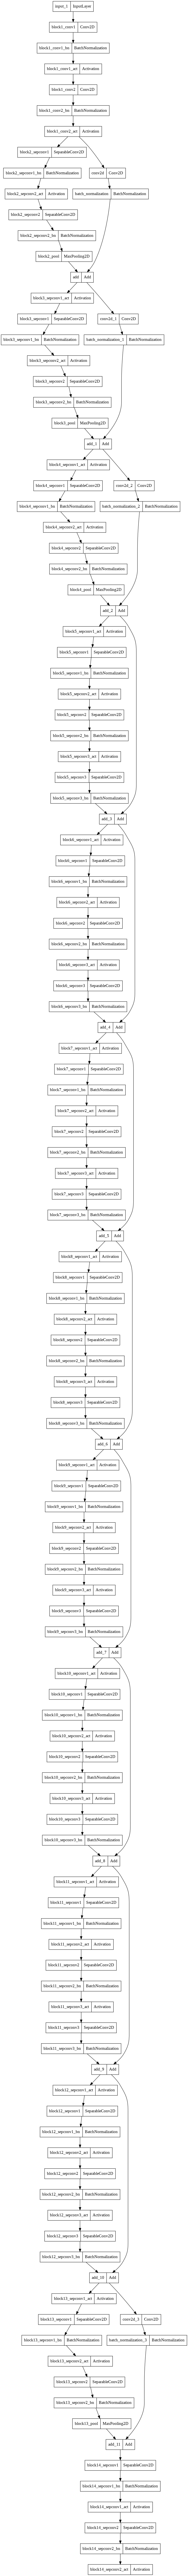

In [27]:
plot_model(modelo, to_file = '/content/drive/MyDrive/Mini-Proyecto/modelo_Xception.png')

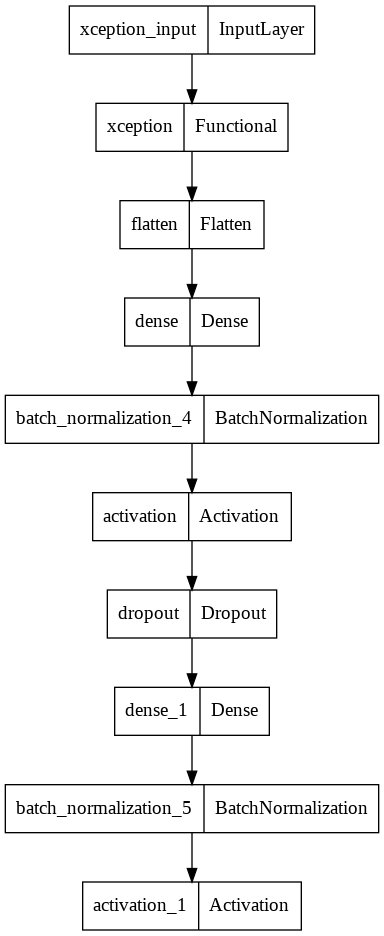

In [28]:
plot_model(modelo2, to_file = '/content/drive/MyDrive/Mini-Proyecto/modelo_2.png')

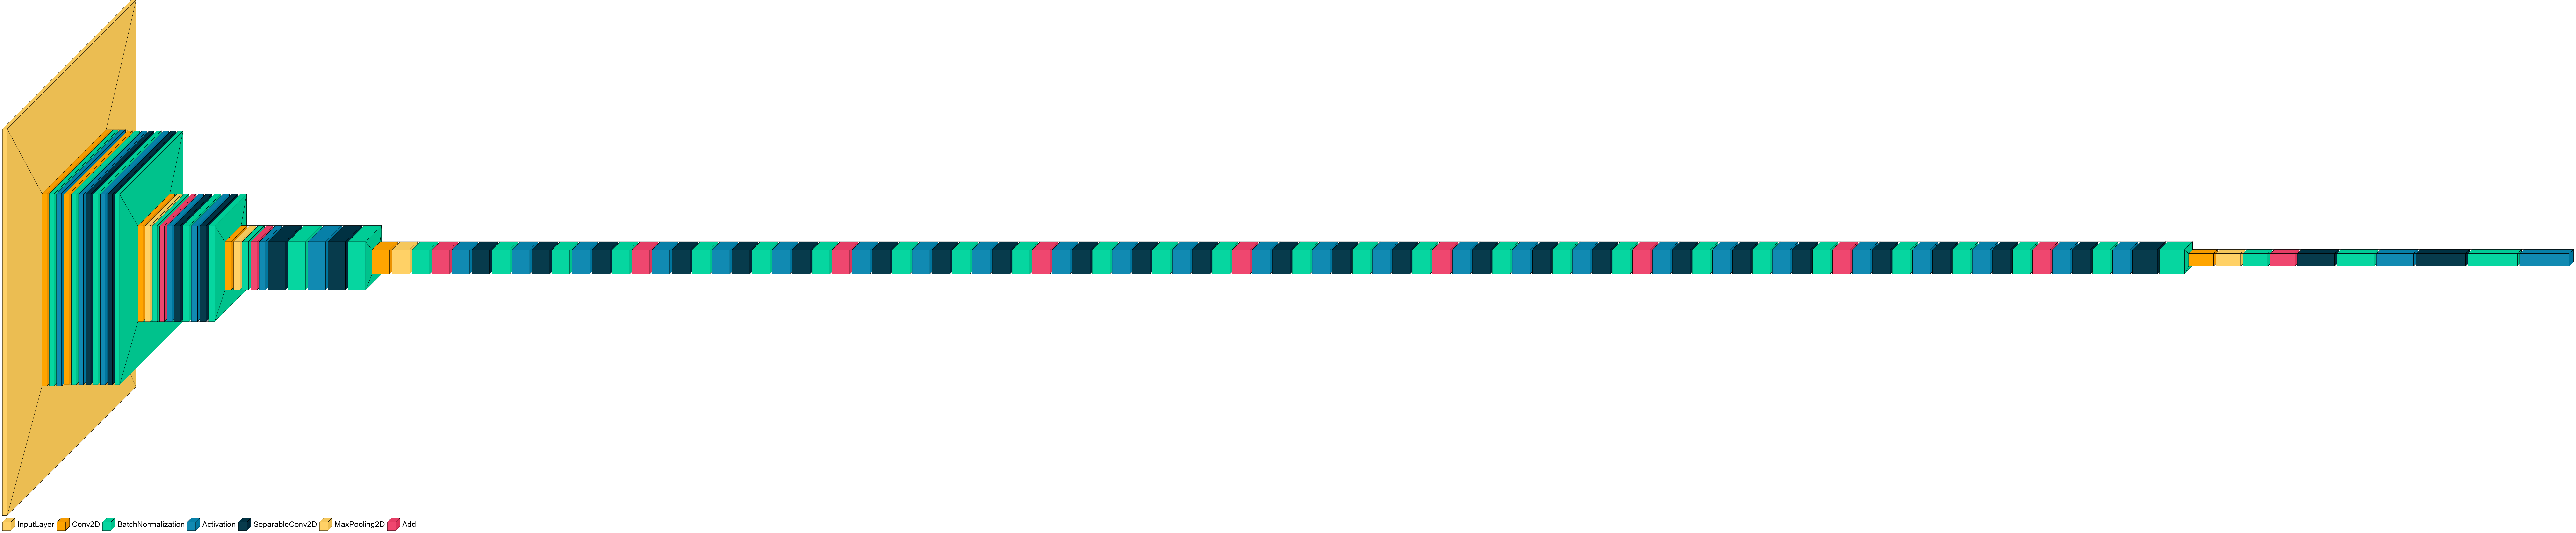

In [54]:
#https://github.com/paulgavrikov/visualkeras/

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[Dropout]['fill'] = 'pink'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(modelo, to_file = '/content/drive/MyDrive/Mini-Proyecto/modelo_Xception_2.png').show()
font = ImageFont.truetype('/content/drive/MyDrive/Tarea 6/arial.ttf', 32)
visualkeras.layered_view(modelo, legend = True, font = font, color_map = color_map)

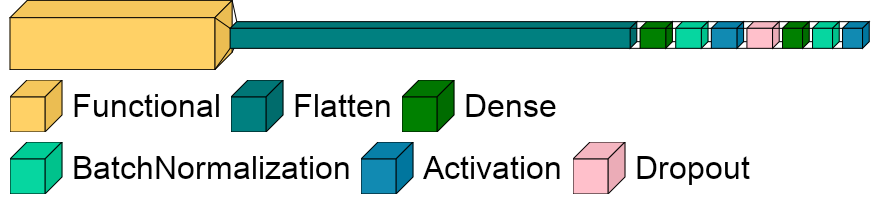

In [55]:
#https://github.com/paulgavrikov/visualkeras/

visualkeras.layered_view(modelo2, to_file = '/content/drive/MyDrive/Mini-Proyecto/modelo_2_2.png').show()
visualkeras.layered_view(modelo2, legend = True, font = font, color_map = color_map)

### Entrenamiento del modelo

In [31]:
# Entrener el modelo
Inicio = time()

reducir_ta = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 1,
                               min_lr = 1e-5, mode = 'min')
parar_modelo = EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 1, min_delta = 1e-5,
                             mode='min')  
callbacks_lista = [parar_modelo, reducir_ta]  

ksst = modelo2.fit(Entrenamiento, epochs = 50, validation_data = Validacion, callbacks = callbacks_lista)

Final = time()
Tiempo_total = Final - Inicio

print('\nTiempo de entrenamiento: {:.0f}h {:.0f}m {:.0f}s.'.format(Tiempo_total // (60 * 60),
                                                                   Tiempo_total // 60,
                                                                   Tiempo_total % 60))

Epoch 1/50
342/342 [==============================] - 1217s 4s/step - loss: 0.8178 - categorical_accuracy: 0.5972 - precision: 0.7116 - recall: 0.4068 - auc: 0.8060 - val_loss: 0.7895 - val_categorical_accuracy: 0.6205 - val_precision: 0.6833 - val_recall: 0.5436 - val_auc: 0.8319 - lr: 0.0010
Epoch 2/50
342/342 [==============================] - 264s 770ms/step - loss: 0.7133 - categorical_accuracy: 0.6607 - precision: 0.7696 - recall: 0.5042 - auc: 0.8572 - val_loss: 0.7476 - val_categorical_accuracy: 0.6122 - val_precision: 0.6704 - val_recall: 0.5045 - val_auc: 0.8325 - lr: 0.0010
Epoch 3/50
342/342 [==============================] - 264s 772ms/step - loss: 0.6909 - categorical_accuracy: 0.6700 - precision: 0.7591 - recall: 0.5306 - auc: 0.8654 - val_loss: 0.7884 - val_categorical_accuracy: 0.6391 - val_precision: 0.6942 - val_recall: 0.5340 - val_auc: 0.8310 - lr: 0.0010
Epoch 4/50
342/342 [==============================] - 264s 771ms/step - loss: 0.6606 - categorical_accuracy: 0.

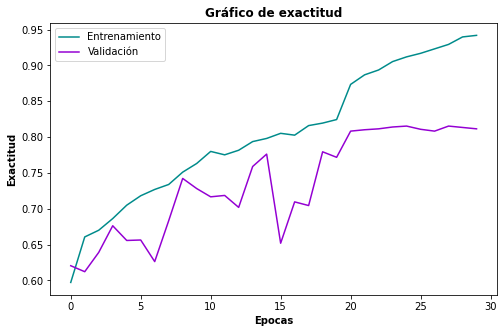

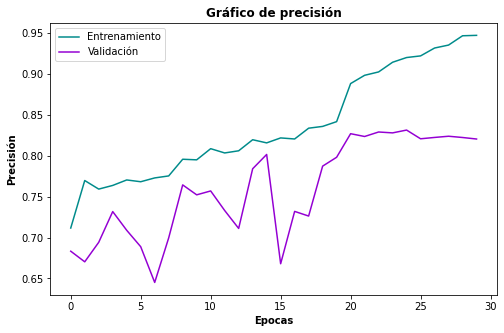

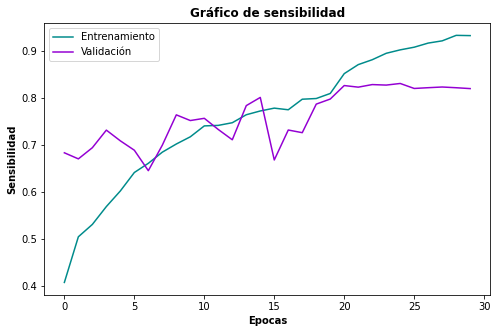

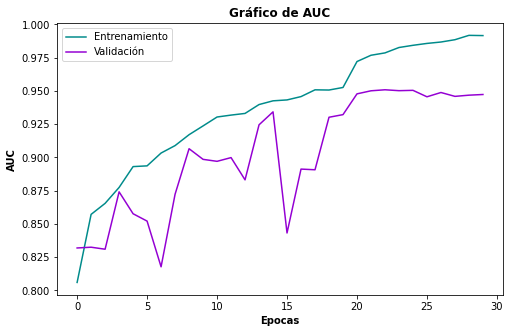

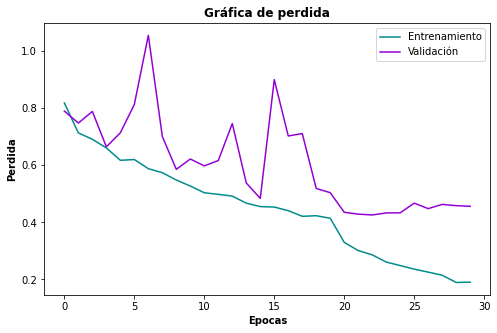

In [32]:
Epocas = range(len(ksst.history['categorical_accuracy']))

# Gráfico de accuracy
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['categorical_accuracy'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_categorical_accuracy'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Exactitud', fontweight = 'bold')
plt.title('Gráfico de exactitud', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de precision
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['precision'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_precision'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Precisión', fontweight = 'bold')
plt.title('Gráfico de precisión', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de recall
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['recall'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_precision'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Sensibilidad', fontweight = 'bold')
plt.title('Gráfico de sensibilidad', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de auc
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['auc'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_auc'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('AUC', fontweight = 'bold')
plt.title('Gráfico de AUC', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfica de loss
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['loss'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_loss'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Perdida', fontweight = 'bold')
plt.title('Gráfica de perdida', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

### Evaluación del modelo

In [33]:
# Evaluación del modelo
# https://stackoverflow.com/questions/63684459/should-i-use-evaluate-generator-or-evaluate-to-evaluate-my-cnn-model
# Se debe usar .fit y .evaluate, porque .fit_generator y .evaluate_generator estan obsoletos
Evaluacion_modelo = modelo2.evaluate(Prueba)
Evaluacion_modelo

50/50 [==============================] - 421s 9s/step - loss: 0.4408 - categorical_accuracy: 0.8089 - precision: 0.8149 - recall: 0.7962 - auc: 0.9492


[0.44078630208969116,
 0.808917224407196,
 0.8148630857467651,
 0.7961783409118652,
 0.9491934776306152]

In [34]:
print(f'Exactitud del conjunto de prueba: {Evaluacion_modelo[1]*100:.2f}%\n')
print(f'Presición del conjunto de prueba: {Evaluacion_modelo[2]*100:.2f}%\n')
print(f'Sensibilidad del conjunto de prueba: {Evaluacion_modelo[3]*100:.2f}%\n')
print(f'Puntaje F1 del conjunto de prueba: {2*(Evaluacion_modelo[2]*Evaluacion_modelo[3])/(Evaluacion_modelo[2]+Evaluacion_modelo[3])*100:.2f}%\n')
print(f'Área bajo la curva del conjunto de prueba: {Evaluacion_modelo[2]*100:.2f}%\n')
print(f'Perdida del conjunto de prueba: {Evaluacion_modelo[0]*100:.2f}%')

Exactitud del conjunto de prueba: 80.89%

Presición del conjunto de prueba: 81.49%

Sensibilidad del conjunto de prueba: 79.62%

Puntaje F1 del conjunto de prueba: 80.54%

Área bajo la curva del conjunto de prueba: 81.49%

Perdida del conjunto de prueba: 44.08%


### Predicción del modelo

In [35]:
# Predecir del conjunto del prueba
# Se usa .predict para predecir
Predecir = modelo2.predict(Prueba)
Predecir

array([[0.9514207 , 0.01404445, 0.03453479],
       [0.91988015, 0.00486785, 0.07525194],
       [0.9878368 , 0.00222921, 0.00993401],
       ...,
       [0.4834362 , 0.00793792, 0.50862586],
       [0.00150416, 0.04749794, 0.9509979 ],
       [0.02806413, 0.00165318, 0.9702827 ]], dtype=float32)

In [36]:
# Etiqueta de las clases
Entrenamiento.class_indices

{'Benigno': 1, 'Cancer': 2, 'Normal': 0}

In [37]:
# Etiquetas del conjunto de prueba
Prueba.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [38]:
# Clasificación
Clasificacion = np.argmax(Predecir, axis=1)
Clasificacion

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 2, 2, 0, 0, 2, 2, 0, 2, 1, 0, 0, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2,
       0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [39]:
# Curva ROC AUC
etiquetas_imagenes = ['Normal', 'Benigno', 'Cancer']
colores = ['darkgreen', 'darkorange', 'darkred']

# Función para calcular el ROC AUC multiclase (sin gráfico)
def multiclass_roc_auc_score_num(y_prueba, y_predicha, average = 'micro'):
    lb = LabelBinarizer()
    lb.fit(y_prueba)
    y_prueba = lb.transform(y_prueba)
    y_predicha = lb.transform(y_predicha)

    return roc_auc_score(y_prueba, y_predicha, average = average)

print(f"Área bajo la curva: {multiclass_roc_auc_score_num(Prueba.classes, Clasificacion)*100:.2f}%\n")

Área bajo la curva: 85.67%



Área bajo la curva: 85.67%



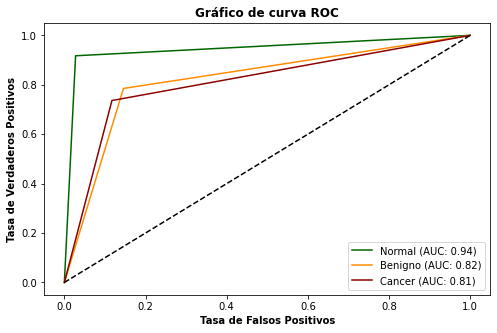

In [40]:
# Curva ROC AUC
etiquetas_imagenes = ['Normal', 'Benigno', 'Cancer']
colores = ['darkgreen', 'darkorange', 'darkred']

# Función para calcular el ROC AUC multiclase (con gráfico)
def multiclass_roc_auc_score(y_prueba, y_predicha, average = 'micro'):
    lb = LabelBinarizer()
    lb.fit(y_prueba)
    y_prueba = lb.transform(y_prueba)
    y_predicha = lb.transform(y_predicha)

    plt.subplots(1,1, figsize = (8, 5))
    for (idx, c_label) in enumerate(etiquetas_imagenes):
        fpr, tpr, thresholds = roc_curve(y_prueba[:, idx].astype(int), y_predicha[:,idx])
        plt.plot(fpr, tpr, label = '%s (AUC: %0.2f)' % (c_label, auc(fpr, tpr)), color = colores[idx])
    plt.plot(fpr, fpr, linestyle = '--', color = 'black')
    return roc_auc_score(y_prueba, y_predicha, average = average)

print(f"Área bajo la curva: {multiclass_roc_auc_score(Prueba.classes, Clasificacion)*100:.2f}%\n")

plt.legend()
plt.title('Gráfico de curva ROC', fontweight = 'bold')
plt.xlabel('Tasa de Falsos Positivos', fontweight = 'bold')
plt.ylabel('Tasa de Verdaderos Positivos', fontweight = 'bold')
plt.show()

In [41]:
# Reporte de clasificación
etiquetas_imagenes = ['Normal', 'Benigno', 'Cancer']

print("Reporte de clasificación:")
print(classification_report(y_true = Prueba.classes, y_pred = Clasificacion,
                            target_names = etiquetas_imagenes))

Reporte de clasificación:
              precision    recall  f1-score   support

      Normal       0.94      0.92      0.93       242
     Benigno       0.74      0.79      0.76       270
      Cancer       0.77      0.74      0.75       273

    accuracy                           0.81       785
   macro avg       0.82      0.81      0.81       785
weighted avg       0.81      0.81      0.81       785



Índices: {'Normal': 0, 'Benigno': 1, 'Cancer': 2} 

Matriz de confusión:
[[222   9  11]
 [  9 212  49]
 [  6  66 201]] 



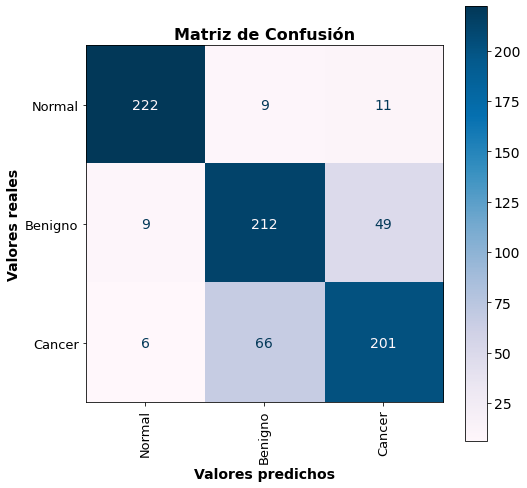



Exactitud: 80.89%

Presición: 80.89%

Sensibilidad: 80.89%

Puntaje F1: 80.89%

Área bajo la curva: 85.67%



In [62]:
# FALTA AGREGAR AUC
# Construcción de matriz de confusión y reporte de clasificación
# https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

font = {'size': 14}
plt.rc('font', **font)

print('Índices:', Entrenamiento.class_indices, '\n')

matriz = confusion_matrix(y_true = Prueba.classes, y_pred = Clasificacion)

print('Matriz de confusión:')
print(matriz, '\n')

disp = ConfusionMatrixDisplay(confusion_matrix = matriz, display_labels = etiquetas_imagenes)
fig, ax = plt.subplots(figsize = (8, 8))
disp = disp.plot(xticks_rotation = 'vertical', ax = ax, cmap = 'PuBu')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('Matriz de Confusión', fontweight = 'bold', fontsize = 16)
plt.xlabel('Valores predichos', fontweight = 'bold', fontsize = 14)
plt.ylabel('Valores reales', fontweight = 'bold', fontsize = 14)
plt.show()

print('\n')
print(f"Exactitud: {accuracy_score(Prueba.classes, Clasificacion)*100:.2f}%\n")
print(f"Presición: {precision_score(Prueba.classes, Clasificacion, average = 'micro')*100:.2f}%\n")
print(f"Sensibilidad: {recall_score(Prueba.classes, Clasificacion, average = 'micro')*100:.2f}%\n")
print(f"Puntaje F1: {f1_score(Prueba.classes, Clasificacion, average = 'micro')*100:.2f}%\n")
print(f"Área bajo la curva: {multiclass_roc_auc_score_num(Prueba.classes, Clasificacion)*100:.2f}%\n")

In [43]:
etiquetas_base = sorted(Entrenamiento.class_indices.items(), key = lambda pair:pair[1])
etiquetas_base = np.array([key.title() for key, value in etiquetas_base])
print(etiquetas_base)

['Normal' 'Benigno' 'Cancer']


In [44]:
img_predecir, img_predecir_etiqueta = next(iter(Prueba2))
verdaderas_etiquetas_ids = np.argmax(img_predecir_etiqueta, axis = -1)
print('Dimensiones de img_predecir:', img_predecir.shape)

Dimensiones de img_predecir: (16, 400, 400, 3)


In [45]:
predicciones_prueba2 = modelo2.predict(img_predecir)
predicciones_prueba2_dataframe = pd.DataFrame(predicciones_prueba2)
predicciones_prueba2_dataframe.columns = etiquetas_base

In [46]:
confianza = []

for i in predicciones_prueba2:
  aux = round(100 * (np.max(i)), 2)
  confianza.append(aux)

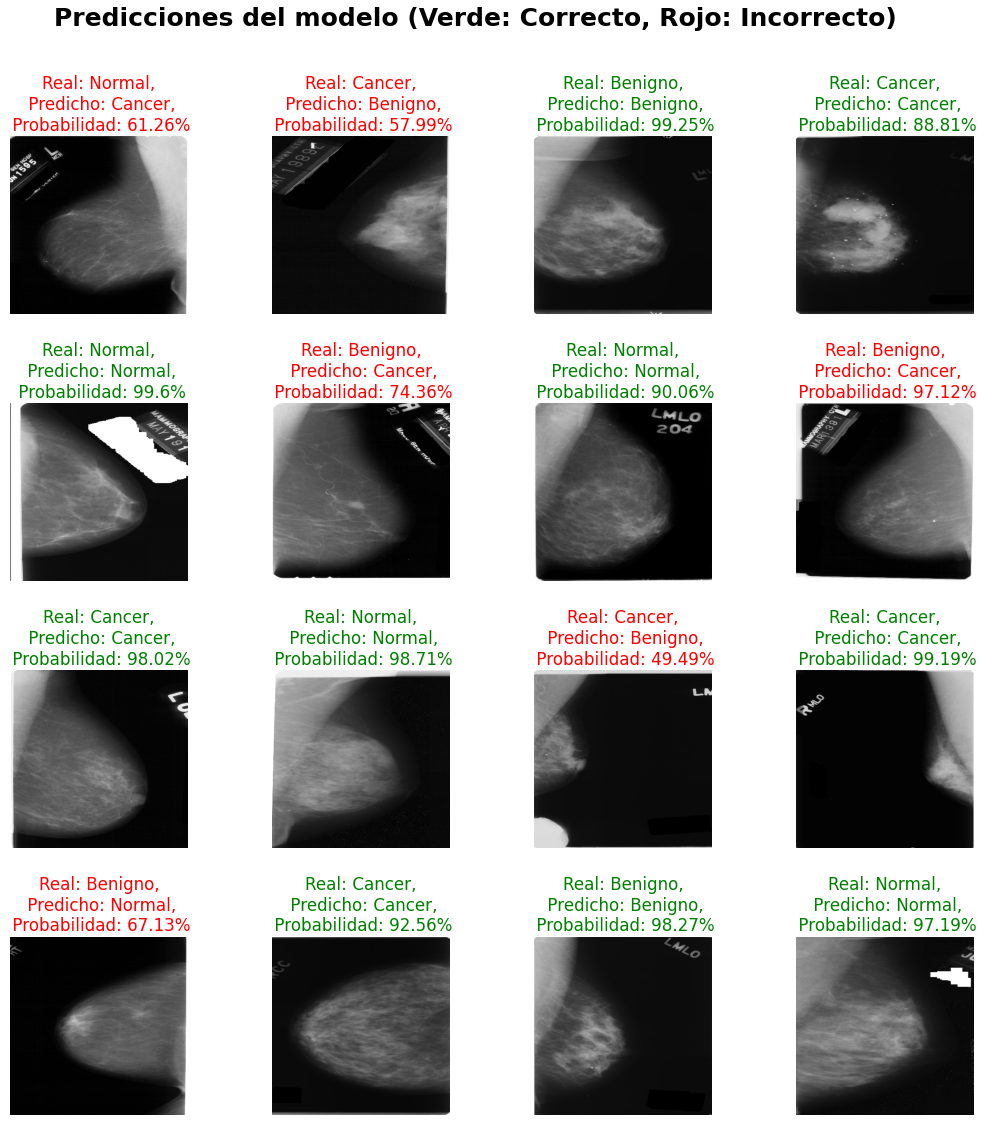

In [47]:
predicciones_ids = np.argmax(predicciones_prueba2, axis = -1)
predicciones_etiquetas = etiquetas_base[predicciones_ids]
actual_etiquetas = etiquetas_base[verdaderas_etiquetas_ids]

plt.figure(figsize = (18, 18))
plt.subplots_adjust(hspace = 0.5)

for n in range(batch_size):
  plt.subplot(4, 4, n + 1)
  plt.imshow(img_predecir[n])
  color = 'green' if predicciones_ids[n] == verdaderas_etiquetas_ids[n] else 'red'
  plt.title(f"Real: {actual_etiquetas[n]},\n Predicho: {predicciones_etiquetas[n]},\n Probabilidad: {confianza[n]}%",
            color = color)
  plt.axis('off')
  _ = plt.suptitle('Predicciones del modelo (Verde: Correcto, Rojo: Incorrecto)', fontweight = 'bold', fontsize = 25)

### Guardar el modelo

In [48]:
# ANTES DE CORRER ESTA LINEA, ASEGURESE DE NO TENER EL MODELO GUARDADO ANTERIORMENTE

# Guardar el modelo
modelo2.save('/content/drive/MyDrive/Mini-Proyecto/Modelo_Mamografia.h5')
#modelo2.save('Modelo_Mamografia.h5')

# Guardar los pesos del modelo
modelo2.save_weights('/content/drive/MyDrive/Mini-Proyecto/Modelo__Pesos_Mamografia.h5')